In [110]:
import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import numpy as np
import pandas as pd
import pymc3 as pm
from scipy import stats
from scipy.special import expit
az.style.use("arviz-darkgrid")

# Beta Regression

In this example, we'll look at using the **Beta distribution** for regression models. The Beta distribution is a probability distribution bounded on the interval [0, 1], which makes it well-suited to model probabilities or proportions. In fact, in much of the Bayesian literature, the Beta distribution is introduced as a prior distribution for the probability $p$ parameter of the Binomial distribution (in fact, it's the conjugate prior for the Binomial distribution).

The Beta distribution is given as:

$f(x|\alpha,\beta) = \frac{x^{\alpha-1}(1-x)^{\beta-1}}{B(\alpha,\beta)}$


where $B$ is the Beta function. The distribution has mean

$\frac{\alpha}{\alpha + \beta}$

and variance

$\frac{\alpha \beta}{(\alpha+\beta)^2 (\alpha + \beta +1)}$

and in pymc, it can be specified by either ($\alpha$,$\beta$) or ($\mu$,$\sigma$).

## Simulated Beta Distribution

To start getting an intuitive sense of the Beta distribution, we'll model coin flipping probabilities. Say we grab all the coins out of our pocket, we might have some fresh from the mint, but we might also have some old ones. Due to the variation, some may be slightly biased, and we would like to model the probabilities of flipping head of the coins in our pockets.

Since we trust the mint, we'll say the $\alpha$ and $\beta$ are both large, 1,000, creating a distribution spanning from 0.45 to 0.55.

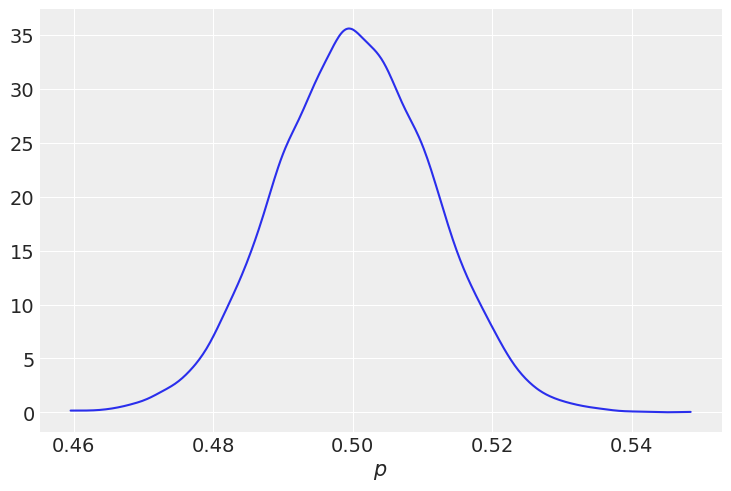

In [3]:
alpha = 1_000
beta = 1_000
p = np.random.beta(alpha, beta, size=10_000)
az.plot_kde(p)
plt.xlabel("$p$");

Next, we'll use Bambi to try to recover the parameters of the Beta distribution. Since we have no predictors, we can do a intercept-only model to try to recover them.

In [4]:
data = pd.DataFrame({"probabilities": p})
model = bmb.Model("probabilities ~ 1", data, family="beta")
fitted = model.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [probabilities_kappa, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 140 seconds.


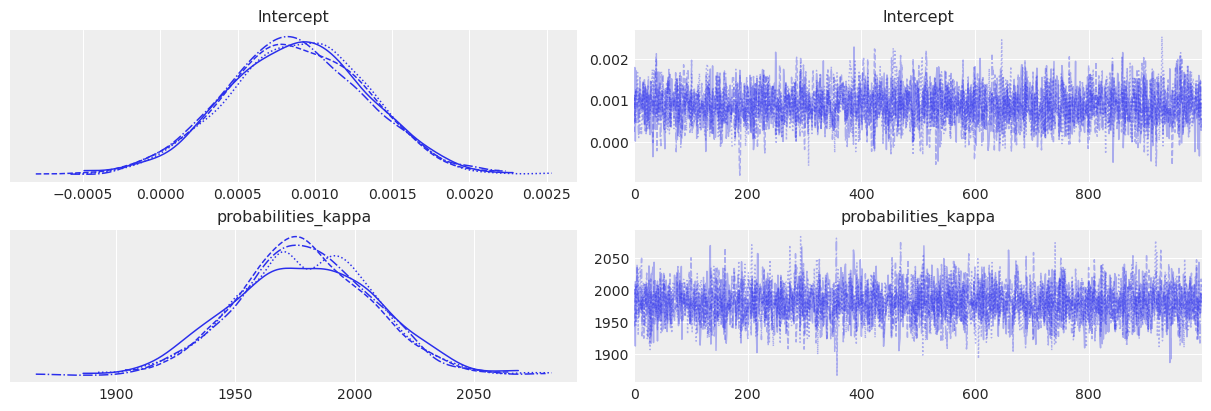

In [5]:
az.plot_trace(fitted);

In [6]:
az.summary(fitted)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.001,0.000,0.000,0.002,0.000,0.000,3496.0,2555.0,1.0
probabilities_kappa,1979.222,28.189,1922.781,2027.362,0.471,0.333,3588.0,2905.0,1.0


The model fit, but clearly these parameters are not the ones that we used above. For Beta regression, we use a linear model for the mean, so we use the $\mu$ and $\sigma$ formulation. To link the two, we use

$\alpha = \mu \kappa$

$\beta = (1-\mu)\kappa$

and $\kappa$ is a function of the mean and variance,

$\kappa = \frac{\mu(1-\mu)}{\sigma^2} - 1$

Rather than $\sigma$, you'll note Bambi returns $\kappa$. We'll define a function to retrieve our original parameters.

In [7]:
def mukappa_to_alphabeta(mu, kappa):
    alpha = mu * kappa
    beta = (1 - mu) * kappa
    return alpha, beta

In [8]:
# Mean Values
alpha, beta = mukappa_to_alphabeta(
    pm.math.invlogit( fitted.posterior.Intercept.mean()),
    fitted.posterior.probabilities_kappa.mean()    
)
# Upper/lower 95%
intercept_hdi = pm.math.invlogit( az.hdi(fitted.posterior, hdi_prob=.95)["Intercept"])
kappa_hdi = az.hdi(fitted.posterior, hdi_prob=.95)["probabilities_kappa"]

alpha_lower, beta_lower = mukappa_to_alphabeta(
    intercept_hdi[0],
    kappa_hdi[0]
)
alpha_upper, beta_upper = mukappa_to_alphabeta(
    intercept_hdi[1],
    kappa_hdi[1]
)
    
                     
print(rf"Alpha - mean: {round(alpha.eval().item())}, 95% HDI: {round(alpha_lower.eval().item())} - {round(alpha_upper.eval().item())}")
print(rf"Beta - mean: {round(beta.eval().item())}, 95% HDI: {round(beta_lower.eval().item())} - {round(beta_upper.eval().item())}")


Alpha - mean: 990, 95% HDI: 960 - 1015
Beta - mean: 989, 95% HDI: 960 - 1014


We've managed to recover our parameters with an intercept-only model.

## Beta Regression with Predictors

Perhaps we have a litle more information on the coins in our pocket. We have a group  that have dirt on the heads side, and a group that have dirt on the tails side. This shifts the probability of getting a tails or heads. In reality, we would not know how much the dirt affects the probability distribution, we would like to recover that parameter. We'll construct this toy example by saying that each micron of dirt shifts the $\alpha$ parameter by 5.0. Further, the amount of dirt is distributed according to a Half Normal distribution with a standard deviation of 25 per side.

We'll start by looking at the difference in probability for a coin with a lot of dirt on either side.

(-1.9436893028868696, 51.02184420078032)

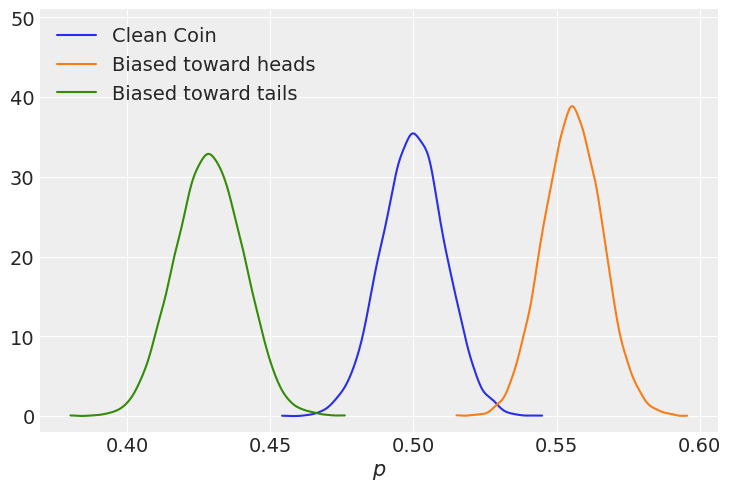

In [9]:
effect_per_micron = 5.0

# Clean Coin
alpha = 1_000
beta = 1_000
p = np.random.beta(alpha, beta, size=10_000)

# Add two std to tails side (heads more likely)
p_heads = np.random.beta(alpha + 50 * effect_per_micron, beta, size=10_000)
# Add two std to heads side (tails more likely)
p_tails = np.random.beta(alpha - 50 * effect_per_micron, beta, size=10_000)

az.plot_kde(p, label="Clean Coin")
az.plot_kde(p_heads, label="Biased toward heads", plot_kwargs={"color":"C1"})
az.plot_kde(p_tails, label="Biased toward tails", plot_kwargs={"color":"C2"})
plt.xlabel("$p$");
plt.ylim(top=plt.ylim()[1]*1.25)


Next, we'll generate a toy dataset according to our specifications above. As an added foil, we will also assume that we're limited in our measuring equipment, that we can only measure correctly to the nearest integer micron.

In [10]:
# Create amount of dirt on top and bottom
heads_bias_dirt = stats.halfnorm(loc=0, scale=25).rvs(size=10_000)
tails_bias_dirt = stats.halfnorm(loc=0, scale=25).rvs(size=10_000)

# Create the probability per coin
alpha = np.repeat(1_000, 10_000)
alpha = alpha + effect_per_micron * heads_bias_dirt - effect_per_micron * tails_bias_dirt
beta = np.repeat(1_000, 10_000)

p = np.random.beta(alpha, beta)

df = pd.DataFrame({
    "p" : p,
    "heads_bias_dirt" : heads_bias_dirt.round(),
    "tails_bias_dirt" : tails_bias_dirt.round()
})
df.head()

,p,heads_bias_dirt,tails_bias_dirt
0,0.491117,5.0,5.0
1,0.488369,14.0,34.0
2,0.505524,15.0,4.0
3,0.527849,47.0,26.0
4,0.510703,21.0,20.0


Taking a look at our new dataset:

Text(0.5, 0, 'Measured Dirt Biasing Toward Tails ($\\mu m$)')

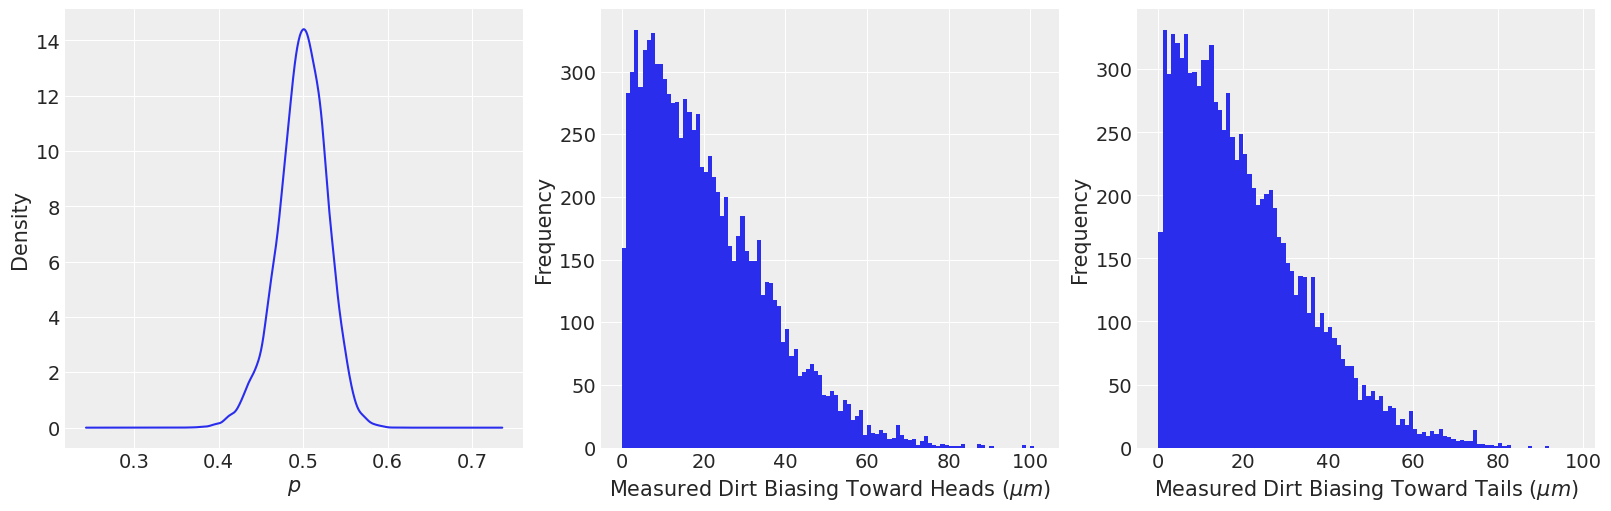

In [11]:
fig,ax = plt.subplots(1,3, figsize=(16,5))

df["p"].plot.kde(ax=ax[0])
ax[0].set_xlabel("$p$")

df["heads_bias_dirt"].plot.hist(ax=ax[1], bins=np.arange(0,df["heads_bias_dirt"].max()))
ax[1].set_xlabel("Measured Dirt Biasing Toward Heads ($\mu m$)")
df["tails_bias_dirt"].plot.hist(ax=ax[2], bins=np.arange(0,df["tails_bias_dirt"].max()))
ax[2].set_xlabel("Measured Dirt Biasing Toward Tails ($\mu m$)")

Next we want to make a model to recover the effect per micron of dirt per side. So far, we've considered the biasing toward one side or another independently. A linear model might look something like this:

$ p \text{ ~ Beta}(\mu, \sigma)$

$logit(\mu) = \text{ Normal}( \alpha + \beta_h d_h + \beta_t d_t)$

Where $d_h$ and $d_t$ is the measured dirt in microns biasing toward heads and tails respectively, $\beta_h$ and $\beta_t$ are coefficients for how much a micron of dirt affects each independent side, and $\alpha$ is the intercept. However, we have no reason to expect that dirt should affect one side differently from another, so we can wrap those into one coefficient: $\beta = \beta_h = -\beta_t$. This makes the last line of the model:

$logit(\mu) = \text{ Normal}( \alpha + \beta \Delta d)$

where

$\Delta d = d_h - d_t$

Putting that into our dataset, then constructing this model in Bambi,

In [12]:
df["delta_d"] = df["heads_bias_dirt"] - df["tails_bias_dirt"]
dirt_model = bmb.Model("p ~ delta_d", df, family="beta")
dirt_fitted = dirt_model.fit()
dirt_model.predict(dirt_fitted, kind="pps", draws=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [p_kappa, Intercept, delta_d]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 107 seconds.


In [13]:
az.summary(dirt_fitted)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-0.006,0.000,-0.007,-0.005,0.000,0.000,3151.0,1543.0,1.0
delta_d,0.005,0.000,0.005,0.005,0.000,0.000,2724.0,1483.0,1.0
p_kappa,1933.827,27.649,1883.096,1985.651,0.524,0.371,2750.0,1283.0,1.0


<AxesSubplot:xlabel='p'>

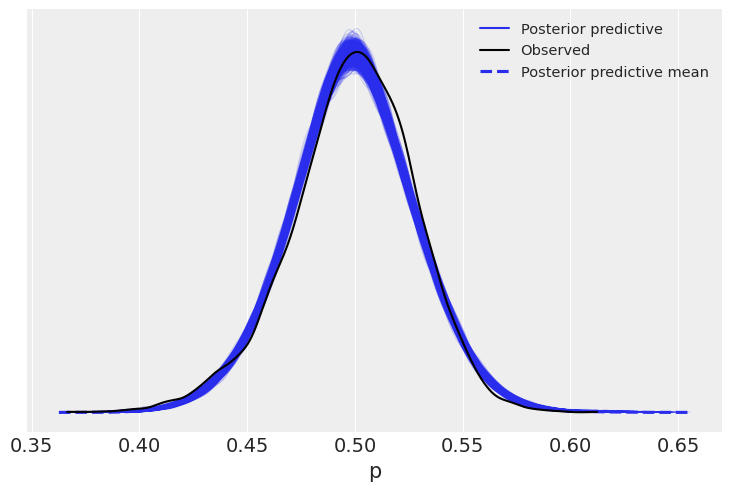

In [14]:
az.plot_ppc(dirt_fitted)

Next, we'll see if we can in fact recover the effect on $\alpha$. Remember that in order to retern to $\alpha$, $\beta$ space, the linear equation passes through a inverse logit transformation, so we must apply this to the coefficient on $\Delta d$ to get the effect on $\alpha$. The inverse logit is nicely defined in `scipy.special` as `expit`.

In [119]:
mean_effect = expit(dirt_fitted.posterior.delta_d.mean())
hdi = az.hdi(dirt_fitted.posterior.delta_d, hdi_prob=.95)
lower = expit(hdi.delta_d[0])
upper = expit(hdi.delta_d[1])
print(f"Mean effect: {mean_effect.item():.4f}")
print(f"95% interval {lower.item():.4f} - {upper.item():.4f}")

Mean effect: 0.5013
95% interval 0.5012 - 0.5013


## Example - Revisiting Baseball Data

In the [Hierarchical Logistic regression with Binomial family](https://bambinos.github.io/bambi/main/notebooks/hierarchical_binomial_bambi.html) notebook, we modeled baseball batting averages (times a player reached first via a hit per times at bat) via a Hierarchical Logisitic regression model. If, we're interested in league-wide effects, we could look at a Beta regression. We work off the assumption that the league-wide batting average follows a Beta distribution, and that individual player's batting averages are samples from that distribtuion.

First, load the Batting dataset again, and re-calculate batting average as hits/at-bat. In order to make sure that we have a sufficient sample, we'll require at least 100 at-bats in order consider a batter. Last, we'll focus in on the fifteen seasons from 1997-2013.

In [35]:
batting = bmb.load_data("batting")

,playerID,yearID,stint,teamID,lgID,G,AB,R,H,2B,...,BB,SO,IBB,HBP,SH,SF,GIDP,batting_avg,batting_avg_shift,std_avg_shift
1,addybo01,1871,1,RC1,NaN,25,118,30,32,6,...,4,0.0,NaN,NaN,NaN,NaN,0.0,0.271186,NaN,NaN
2,allisar01,1871,1,CL1,NaN,29,137,28,40,4,...,2,5.0,NaN,NaN,NaN,NaN,1.0,0.291971,NaN,NaN
3,allisdo01,1871,1,WS3,NaN,27,133,28,44,10,...,0,2.0,NaN,NaN,NaN,NaN,0.0,0.330827,NaN,NaN
4,ansonca01,1871,1,RC1,NaN,25,120,29,39,11,...,2,1.0,NaN,NaN,NaN,NaN,0.0,0.325000,NaN,NaN
7,barnero01,1871,1,BS1,NaN,31,157,66,63,10,...,13,1.0,NaN,NaN,NaN,NaN,1.0,0.401274,NaN,NaN


In [43]:
batting["batting_avg"] = batting["H"] / batting["AB"]
batting = batting[batting["AB"] > 100]

# To make fitting faster
df = batting[ (batting["yearID"] > 1990) & (batting["yearID"] < 2018) ]

Text(0, 0.5, 'Count')

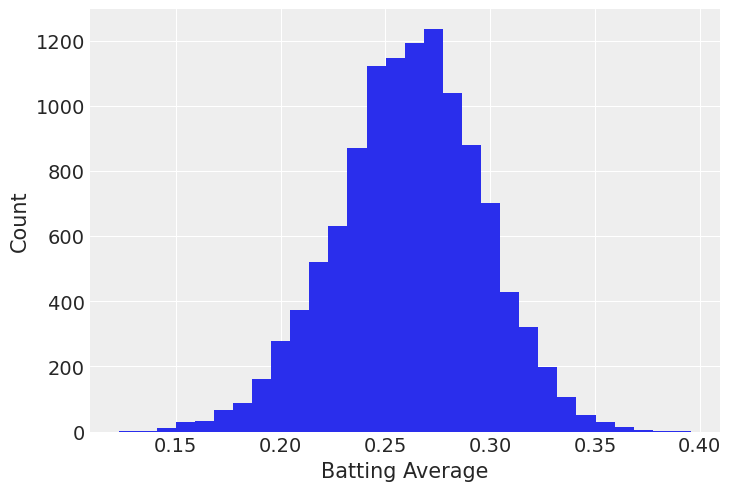

In [44]:
df.batting_avg.hist(bins=30)
plt.xlabel("Batting Average")
plt.ylabel("Count")

If we're interested in modeling the distribution of batting averages, we can start with an intercept-only model.

In [45]:
model_avg = bmb.Model("batting_avg ~ 1", df, family="beta")
avg_fitted = model_avg.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [batting_avg_kappa, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 135 seconds.


In [46]:
az.summary(avg_fitted)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-1.038,0.002,-1.041,-1.035,0.000,0.000,3695.0,2986.0,1.0
batting_avg_kappa,152.592,1.981,148.748,155.995,0.034,0.024,3465.0,2794.0,1.0


Looking at the posterior predictive,

In [47]:
posterior_predictive = model_avg.predict(avg_fitted, kind="pps", draws=1000)

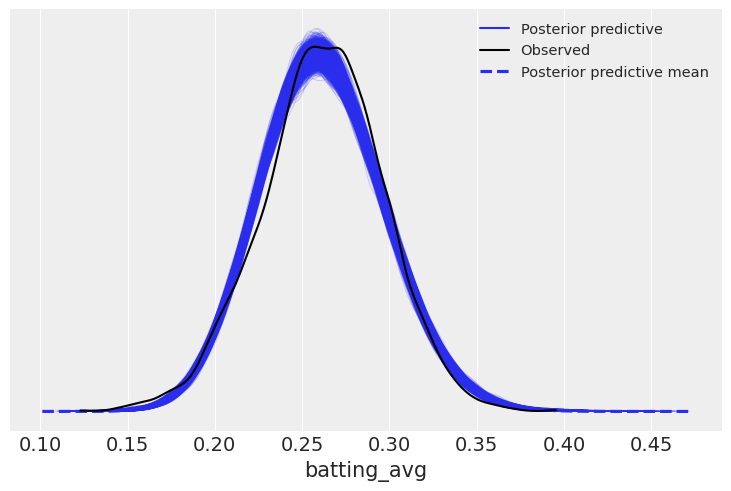

In [48]:
az.plot_ppc(avg_fitted);

This appears to fit reasonably well. If, for example, we were interested in simulating players, we could sample from this distribution.

However, we can take this further. Say we're interested in understanding how this distribution shifts if we know a player's batting average in a previous year. We can condition the model on a player's n-1 year, and use Beta regrssion to model that. Let's construct that variable (note, we'll also standardize it here too).

In [59]:
def standardize(v):
    return (v-v.mean())/ v.std()

In [60]:
# Add the player's batting average in the n-1 year
batting["batting_avg_shift"] = np.where(
    batting["playerID"] == batting["playerID"].shift(),
    batting["batting_avg"].shift(),
    np.nan
)
#batting["std_avg_shift"] = standardize(batting["batting_avg_shift"])

df_shift = batting[ (batting["yearID"] > 1990) & (batting["yearID"] < 2018) ]
df_shift = df_shift[~df_shift["std_avg_shift"].isna()]
df_shift[["std_avg_shift","batting_avg"]].corr()

,std_avg_shift,batting_avg
std_avg_shift,1.000000,0.229774
batting_avg,0.229774,1.000000


 There is a lot of variance in year-to-year batting averages, it's not known to be an incredibly predictive, we see that here. A correlation coefficient of 0.23 is only lightly predictive. However, we can still use it in our model to get a better understanding. We'll fit two models. First, we'll refit the prior, intercept-only, model using this updated dataset so we have an apples-to-apples comparison. Then, we'll fit a moodel using the previous year's batting average as a predictor.

In [61]:
model_avg = bmb.Model("batting_avg ~ 1", df_shift, family="beta")
avg_fitted = model_avg.fit()

model_lag = bmb.Model("batting_avg ~ batting_avg_shift", df_shift, family="beta")
lag_fitted = model_lag.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [batting_avg_kappa, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 135 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [batting_avg_kappa, Intercept, batting_avg_shift]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.


In [50]:
az.summary(lag_fitted)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-1.379,0.072,-1.505,-1.241,0.002,0.001,2267.0,1441.0,1.0
batting_avg_shift,1.364,0.271,0.816,1.819,0.006,0.004,2231.0,1510.0,1.0
batting_avg_kappa,135.803,9.599,118.016,153.470,0.188,0.134,2614.0,1434.0,1.0


In [57]:
az.compare({
    "intercept-only" : avg_fitted,
    "lag-model": lag_fitted
})

C:\Users\tburch\.julia\conda\3\envs\bmb-env\lib\site-packages\arviz\stats\stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(


,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
lag-model,0,784.921538,3.120896,0.000000,0.99673,14.567716,0.000000,False,log
intercept-only,1,774.002639,2.241134,10.918899,0.00327,15.388144,4.657907,False,log


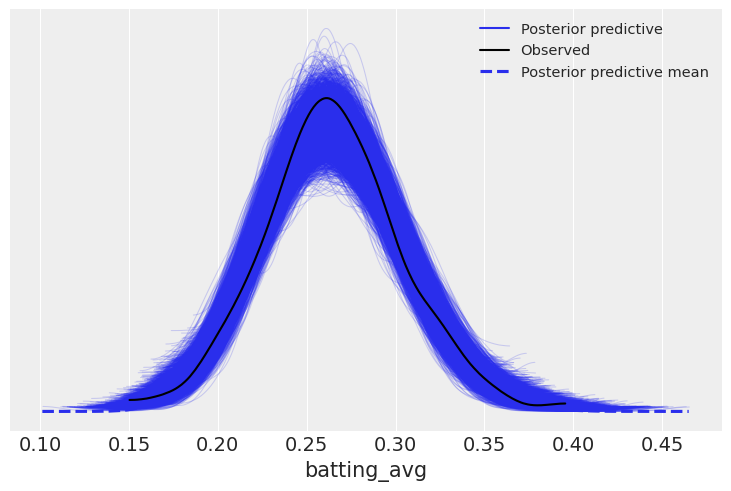

In [ ]:
ppc= model_lag.predict(lag_fitted, kind="pps", draws=1000)
az.plot_ppc(lag_fitted);

The biggest question this helps us understand is, for each point of batting average in the previous year, how much better do we expect a player to be in the current year?

In [120]:
mean_effect = expit(lag_fitted.posterior.batting_avg_shift.mean()).item()

hdi = az.hdi(lag_fitted.posterior.batting_avg_shift, hdi_prob=.95)
lower = expit(hdi.batting_avg_shift[0]).item()
upper = expit(hdi.batting_avg_shift[1]).item()
print(f"Mean effect: {mean_effect:.4f}")
print(f"95% interval {lower:.4f} - {upper:.4f}")

intercept = pm.math.invlogit(lag_fitted.posterior.Intercept.mean()).eval()

Mean effect: 0.7957
95% interval 0.6964 - 0.8711


Text(0, 0.5, 'Batting Average')

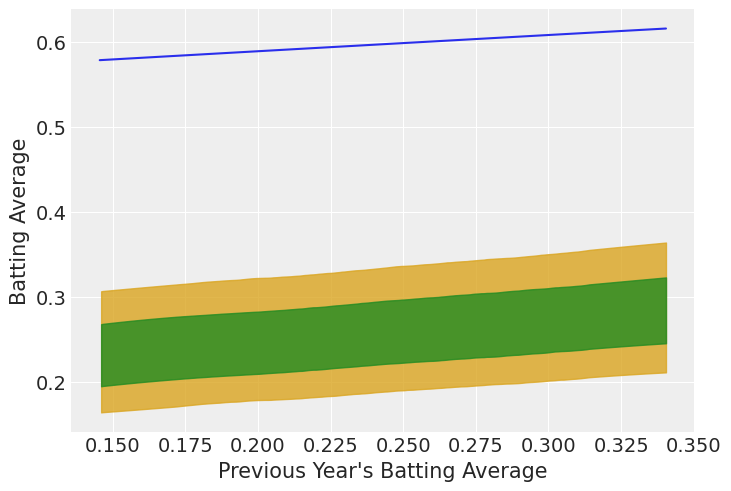

In [122]:
az.plot_hdi(df_shift.batting_avg_shift, lag_fitted.posterior_predictive.batting_avg, hdi_prob=0.95, color="goldenrod", fill_kwargs={"alpha":0.8})
az.plot_hdi(df_shift.batting_avg_shift, lag_fitted.posterior_predictive.batting_avg, hdi_prob=.68, color="forestgreen", fill_kwargs={"alpha":0.8})

x = np.linspace(df_shift.batting_avg_shift.min(), df_shift.batting_avg_shift.max(),100)
linear = mean_effect * x + intercept
plt.plot(x, expit(linear))
plt.xlabel("Previous Year's Batting Average")
plt.ylabel("Batting Average")